## Import Statements

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import stats

c:\Users\jslon\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Functions

In [2]:
def GetKeithly(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,8)),encoding='latin-1')
    vals = df['Reading'].values
    return vals
  except:
    print(f'Error reading {filename}')

def GetKeithTimes(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,8)),encoding='latin-1')
    vals = df['Relative Time'].values
    return vals
  except:
    print(f'Error reading {filename}')

def GetKeysight(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,1)),encoding='latin-1')
    vals = df['Reading'].values
    return vals
  except:
    print(f'Error reading {filename}')

def QHRead(ver: str, QHnum = '1'):
  PWRvals = np.arange(-40,10,1)
  Keithfile = 'QH_'+ QHnum + '-4_' + ver + '.csv'
  Keyfile = 'QH_' + QHnum + '-2_' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Keyvals = GetKeysight(Keyfile)
  vals_1_4 = []
  vals_1_2 = []
  for i in range(1,51):
    vals_1_4.append(Keithvals[(i-1)*1000:i*1000])
    vals_1_2.append(Keyvals[(i-1)*1000:i*1000])
  return PWRvals, vals_1_4, vals_1_2

lfunc647 = lambda x: 1.066*x - 0.00006203
efunc647 = lambda x: -17.18*np.exp(-0.062*x) + 17.18
sfunc647 = lambda x: 0.02852*np.sin(38.03*x + 5.907) + 0.01046

corrfunc = lambda v647: efunc647(v647)

def UnitPrefix(val):
  prefixes = {9:'G', 6:'M', 3:'k', 0:'', -3:'m', -6:'μ', -9:'n'}
  exp1 = 3*(np.log10(val)//3)
  uscale = 10**exp1
  return prefixes[exp1], uscale

def detRead(ver: str, PWRvals: np.ndarray, detnum = '646', sweepnum='1'):
  Keithfile = detnum + 'Sweep' + sweepnum + '_' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  detvals = []
  for i in range(1,51): #Fix
    detvals.append(Keithvals[(i-1)*1000:i*1000])
  return detvals

def PassthroughRead(ver: str, PWRvals: np.ndarray):
  Keithfile = 'QHPassthrough' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Passvals = []
  for i in range(1,51): #Fix
    Passvals.append(Keithvals[(i-1)*1000:i*1000])
  return Passvals

def CombineRead(ver: str, PWRvals: np.ndarray):
  Keithfile = 'Combine' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Combvals = []
  for i in range(1,51): #Fix
    Combvals.append(Keithvals[(i-1)*1000:i*1000])
  return Combvals

def SeriesDuration(ver: str, PWR: str):
  Filename = '646_' + PWR + '_' + 'TimeSeries' + ver + '.csv'
  t1 = GetKeithTimes(Filename)
  duration = (t1[-1]-t1[0])
  hours = duration//3600
  minutes = (duration%3600)//60
  seconds = duration%60
  print(f'{PWR}dBm {ver} lasted {round(hours)}hr {round(minutes)}min {round(seconds)}s')
  return duration

def SeriesRead(ver: str, PWR: str, detnum: str, machine: str, slice_size: int):
  Filename = detnum + '_' + PWR + '_' + 'TimeSeries' + ver + '.csv'
  if machine == 'Keithly':
    Series = GetKeithly(Filename)
  elif machine == 'Keysight':
    Series = GetKeysight(Filename)
  else:
    raise ValueError('Machine musy be either Keithly or Keysight')
  n = len(Series)
  Sliced_Vals = []
  for i in range(0,n,slice_size):
    Sliced_Vals.append(1000*np.abs(Series[i:i+slice_size]))
  return Sliced_Vals

def SeriesPlot(ver: str, PWR: str, sampling_freq: int, Slice_Size: int, Scatter_Slice: int, n: int, aperture: float, figsize=(20,9), alpha=0.05, size=4, normalized=False, timescale='seconds'):
  if timescale == 'seconds':
    xscale = 1
    tlabel = 'Time(s)'
  elif timescale == 'minutes':
    xscale = 60
    tlabel = 'Time(min)'
  elif timescale == 'hours':
    xscale = 3600
    tlabel = 'Time(hr)'
  else:
    raise ValueError('timescale must be either seconds, minutes, or hours')

  S1a = np.array(SeriesRead(ver,PWR,'646','Keithly',Slice_Size))
  S2a = np.array(SeriesRead(ver,PWR,'647','Keysight',Slice_Size))
  Series_646 = np.array([np.mean(valarray) for valarray in S1a])
  Series_647 = np.array([np.mean(valarray) for valarray in S2a])
  total = Series_646 + Series_647
  frac646 = 100*Series_646/total
  frac647 = 100*Series_647/total

  S1s = np.array(SeriesRead(ver,PWR,'646','Keithly',Scatter_Slice))
  S2s = np.array(SeriesRead(ver,PWR,'647','Keysight',Scatter_Slice))
  sSeries_646 = np.array([np.mean(valarray) for valarray in S1s])
  sSeries_647 = np.array([np.mean(valarray) for valarray in S2s])
  stotal = sSeries_646 + sSeries_647
  sfrac646 = 100*sSeries_646/stotal
  sfrac647 = 100*sSeries_647/stotal

  xvals = np.arange(0,n,Slice_Size)/(sampling_freq*xscale)
  xvals_scatter = np.arange(0,n,Scatter_Slice)/(sampling_freq*xscale)

  if normalized:
    norm = 100/stotal.max()
  else:
    norm = 1

  normdict = {True:'Is Normalized', False:'Is Not Normalized'}

  total = total*norm
  Series_646 = Series_646*norm
  Series_647 = Series_647*norm

  stotal = stotal*norm
  sSeries_646 = sSeries_646*norm
  sSeries_647 = sSeries_647*norm

  bound1 = np.array([sSeries_646,sSeries_647])
  bound2 = np.array([sfrac646,sfrac647])
  bound3 = stotal

  fig1 = plt.figure(figsize=(20,9))
  alpha1 = 0.05
  size1 = 4

  prefix, uscale = UnitPrefix(aperture)

  print(f'There are {n} Points In Total')
  print(f'The Sampling Rate is {sampling_freq}Hz')
  print(f'Aperture is {int(aperture//uscale)} {prefix}s')
  print(f'Line Plots Averaging Every {Slice_Size} Points')
  print(f'Scatter Plots Averaging Every {Scatter_Slice} Points')
  print(f'Timescale units are {timescale}')
  print(f'Signal {normdict[normalized]}')
  print('')

  plt.subplot(2, 3, 1)
  plt.plot(xvals,Series_646,'-b',label=f'det646: {PWR}dBm')
  plt.plot(xvals,Series_647,'-r',label=f'det647: {PWR}dBm')
  plt.scatter([0,0],[bound1.min(),bound1.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 2)
  plt.plot(xvals,frac646,'-b',label=f'det646: {PWR}dBm')
  plt.plot(xvals,frac647,'-r',label=f'det647: {PWR}dBm')
  plt.scatter([0,0],[bound2.min(),bound2.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Power Fraction')
  plt.title(f'Power Fraction vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 3)
  plt.plot(xvals,total,'-g',label=f'Total: {PWR}dBm')
  plt.scatter([0,0],[bound3.min(),bound3.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Total Power')
  plt.title(f'Total Power vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 4)
  plt.scatter(xvals_scatter,sSeries_646,c='b',s=size,alpha=alpha)
  plt.scatter(xvals_scatter,sSeries_647,c='r',s=size,alpha=alpha)
  plt.plot([],[],'.b',label=f'det646: {PWR}dBm'); plt.plot([],[],'.r',label=f'det647: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 5)
  plt.scatter(xvals_scatter,sfrac646,c='b',s=size,alpha=alpha)
  plt.scatter(xvals_scatter,sfrac647,c='r',s=size,alpha=alpha)
  plt.plot([],[],'.b',label=f'det646: {PWR}dBm'); plt.plot([],[],'.r',label=f'det647: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Power Fraction')
  plt.title(f'Power Fraction vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 6)
  plt.scatter(xvals_scatter,stotal,c='g',s=size,alpha=alpha)
  plt.plot([],[],'.g',label=f'Total: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Total Power')
  plt.title(f'Total Power vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.tight_layout()

  return

## 2 way splitter data, dmm settings

The same experiment as the previous notebook is done, with varying sampling rates and aperture settings, this also causes different series durations

In [3]:
#All these using basic 2-way splitter setup9
#50ms aperture 1sampling rate - v3
#7ms aperture 7sampling rate - v4 - 1000total - started using other function gen to trigger
#11-04 - v4
#12-11 - v5
#5ms aperture 10sampling rate - v5

In [4]:
#Add in start time option to function
#Splitter to QH
#Other source
#Long detector time-series
#Directional coupler dependance test

In [5]:
Normv3 = True

In [6]:
d1 = SeriesDuration('v3','+00')
d2 = SeriesDuration('v4','+00')
d3 = SeriesDuration('v5','+00')

+00dBm v3 lasted 14hr 2min 42s
+00dBm v4 lasted 0hr 2min 23s
+00dBm v5 lasted 1hr 23min 20s


There are 50000 Points In Total
The Sampling Rate is 1Hz
Aperture is 50 ms
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are hours
Signal Is Normalized



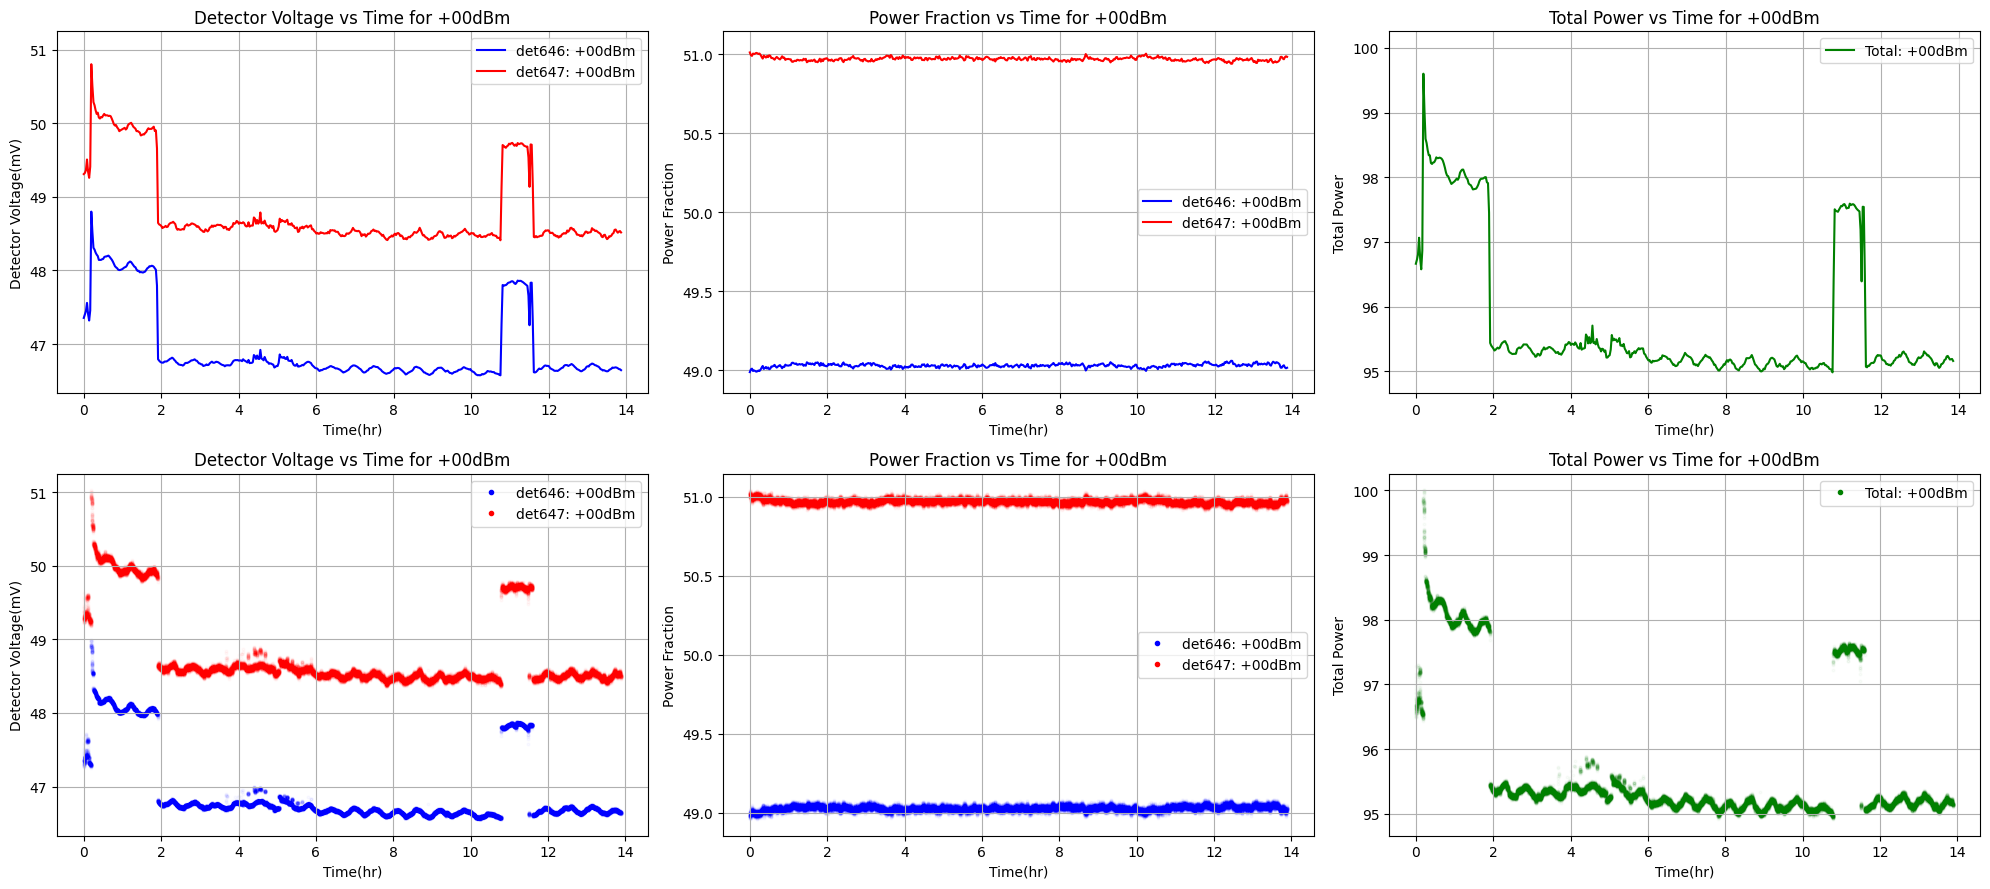

In [7]:
SeriesPlot(ver='v3', PWR='+00', sampling_freq=1, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=50e-3, figsize=(20,9), alpha=0.025, size=4, normalized=Normv3, timescale='hours')

There are 1000 Points In Total
The Sampling Rate is 7Hz
Aperture is 7 ms
Line Plots Averaging Every 2 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



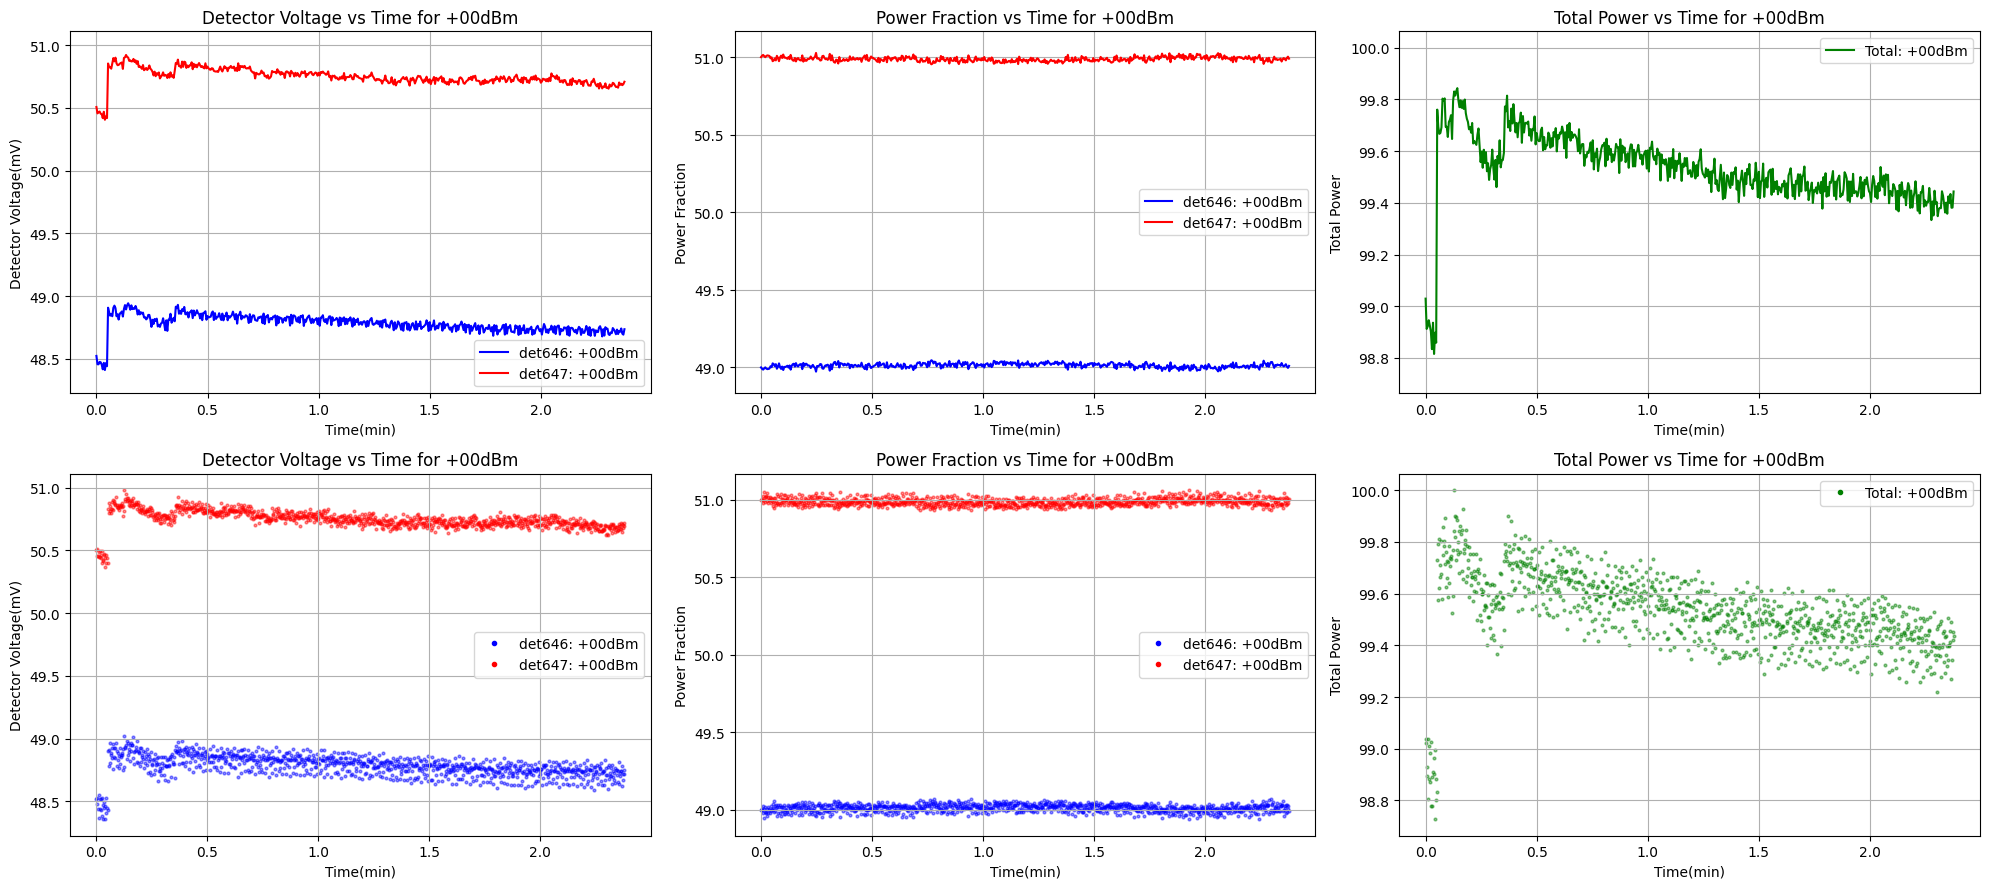

In [8]:
SeriesPlot(ver='v4', PWR='+00', sampling_freq=7, Slice_Size=2, Scatter_Slice=1, n=1000, aperture=7e-3, figsize=(20,9), alpha=0.45, size=4, normalized=Normv3, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 10Hz
Aperture is 5 ms
Line Plots Averaging Every 500 Points
Scatter Plots Averaging Every 1 Points
Timescale units are hours
Signal Is Normalized



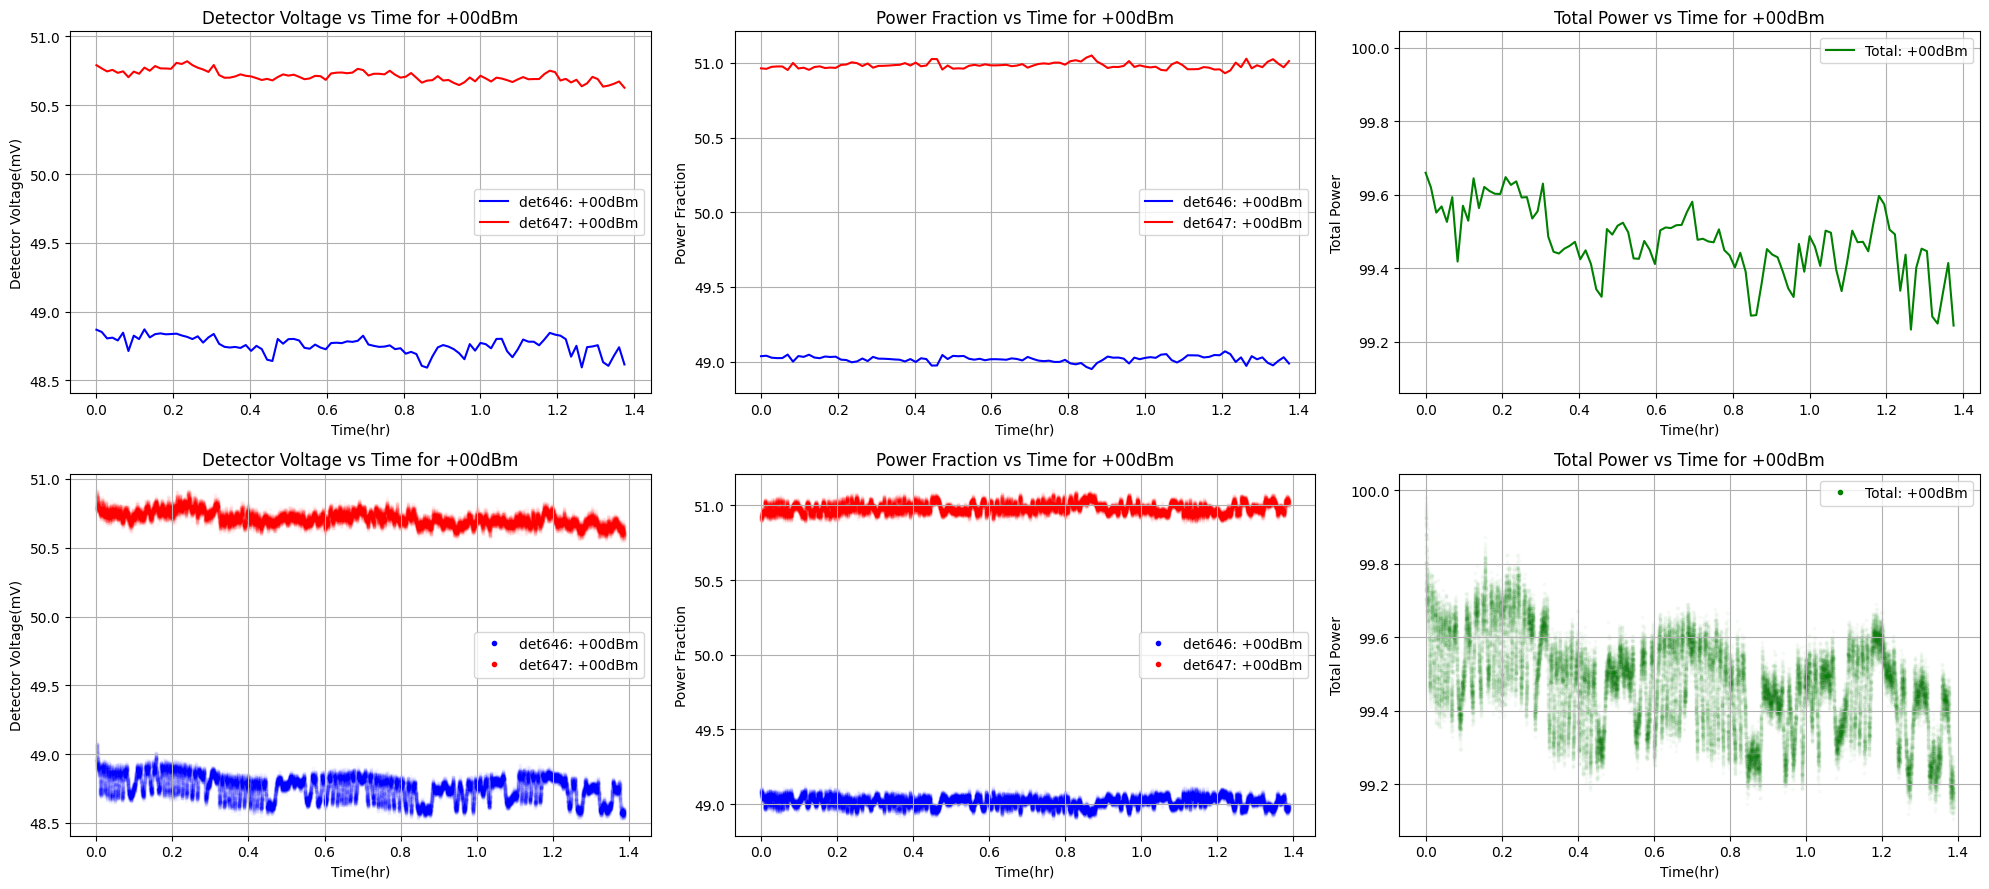

In [9]:
SeriesPlot(ver='v5', PWR='+00', sampling_freq=10, Slice_Size=500, Scatter_Slice=1, n=50000, aperture=5e-3, figsize=(20,9), alpha=0.025, size=4, normalized=Normv3, timescale='hours')

A clear sinusoidal oscillation in total power can be seen

## 2 way splitter data, varying power

In [10]:
#v6: 500us aperture 50Hz sampling 2way splitter to QH1 settings in pictures Source A
#-40dBm 14:14 7/15
#-30dBm 14:32 7/15
#-20dBm 14:50 7/15
#-10dBm 15:09 7/15
#+00dBm 11:06 7/16
#+10dBm 11:28 7/16
#+20dBm 11:51 7/16

In [11]:
Normv4 = True

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



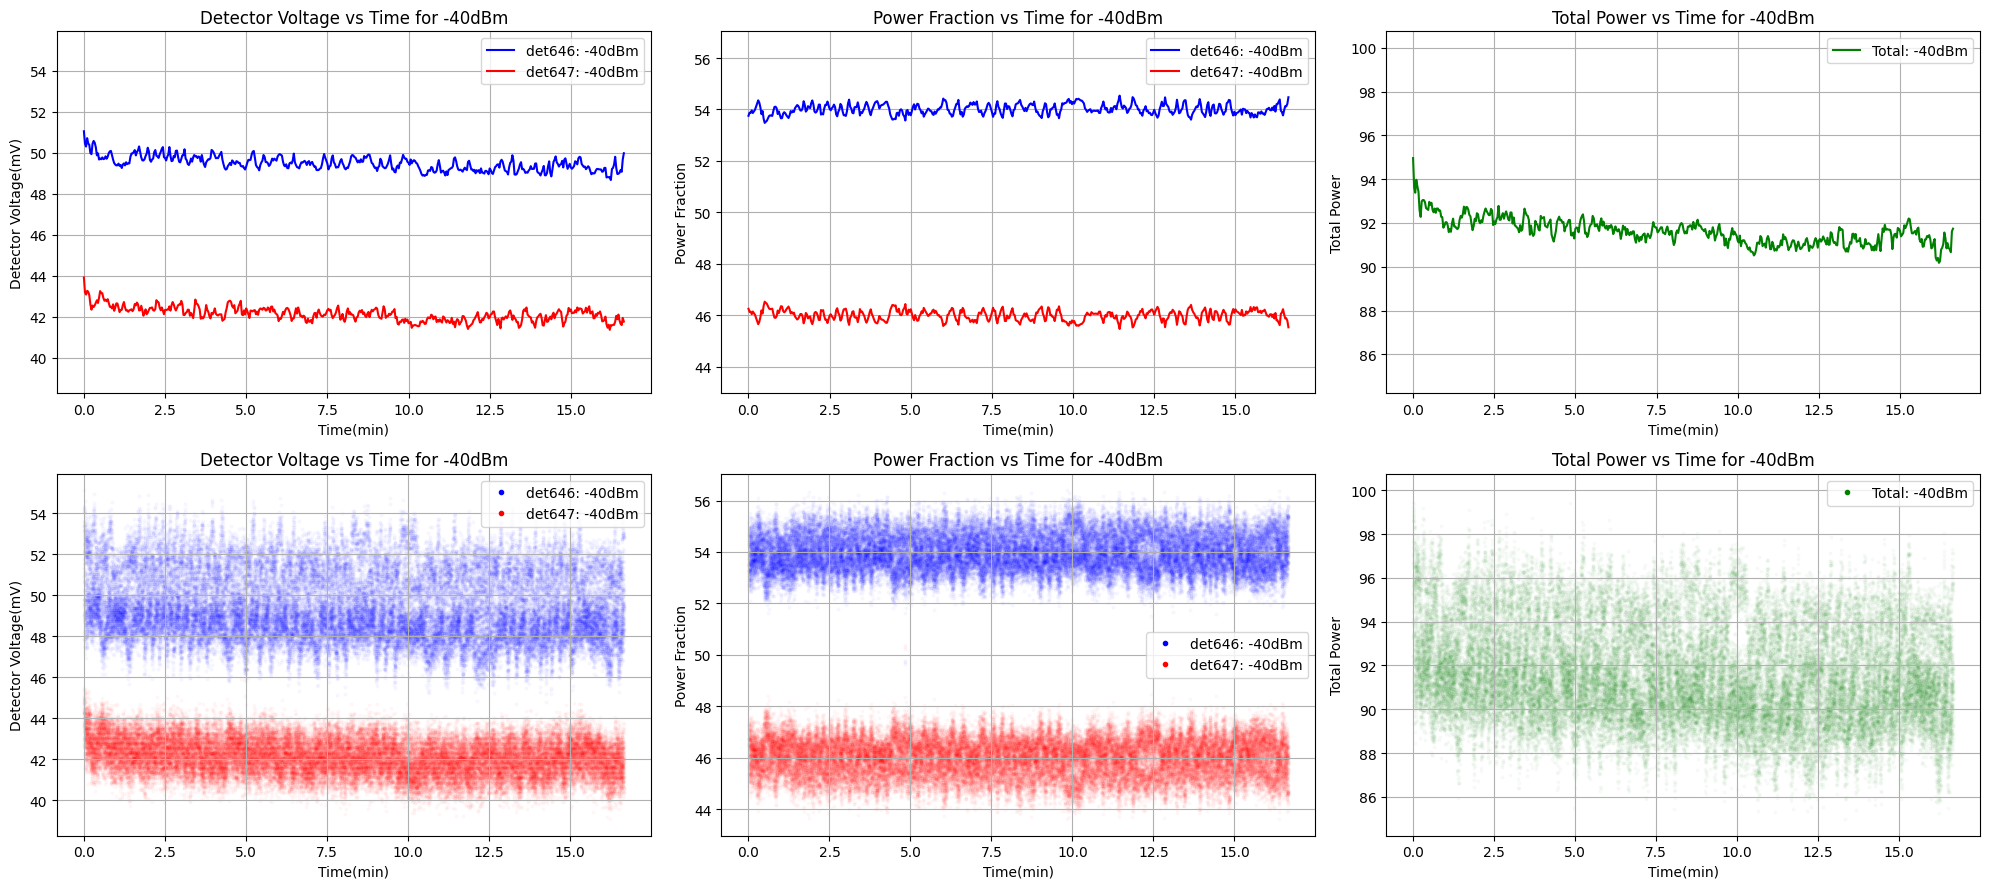

In [12]:
SeriesPlot(ver='v6', PWR='-40', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



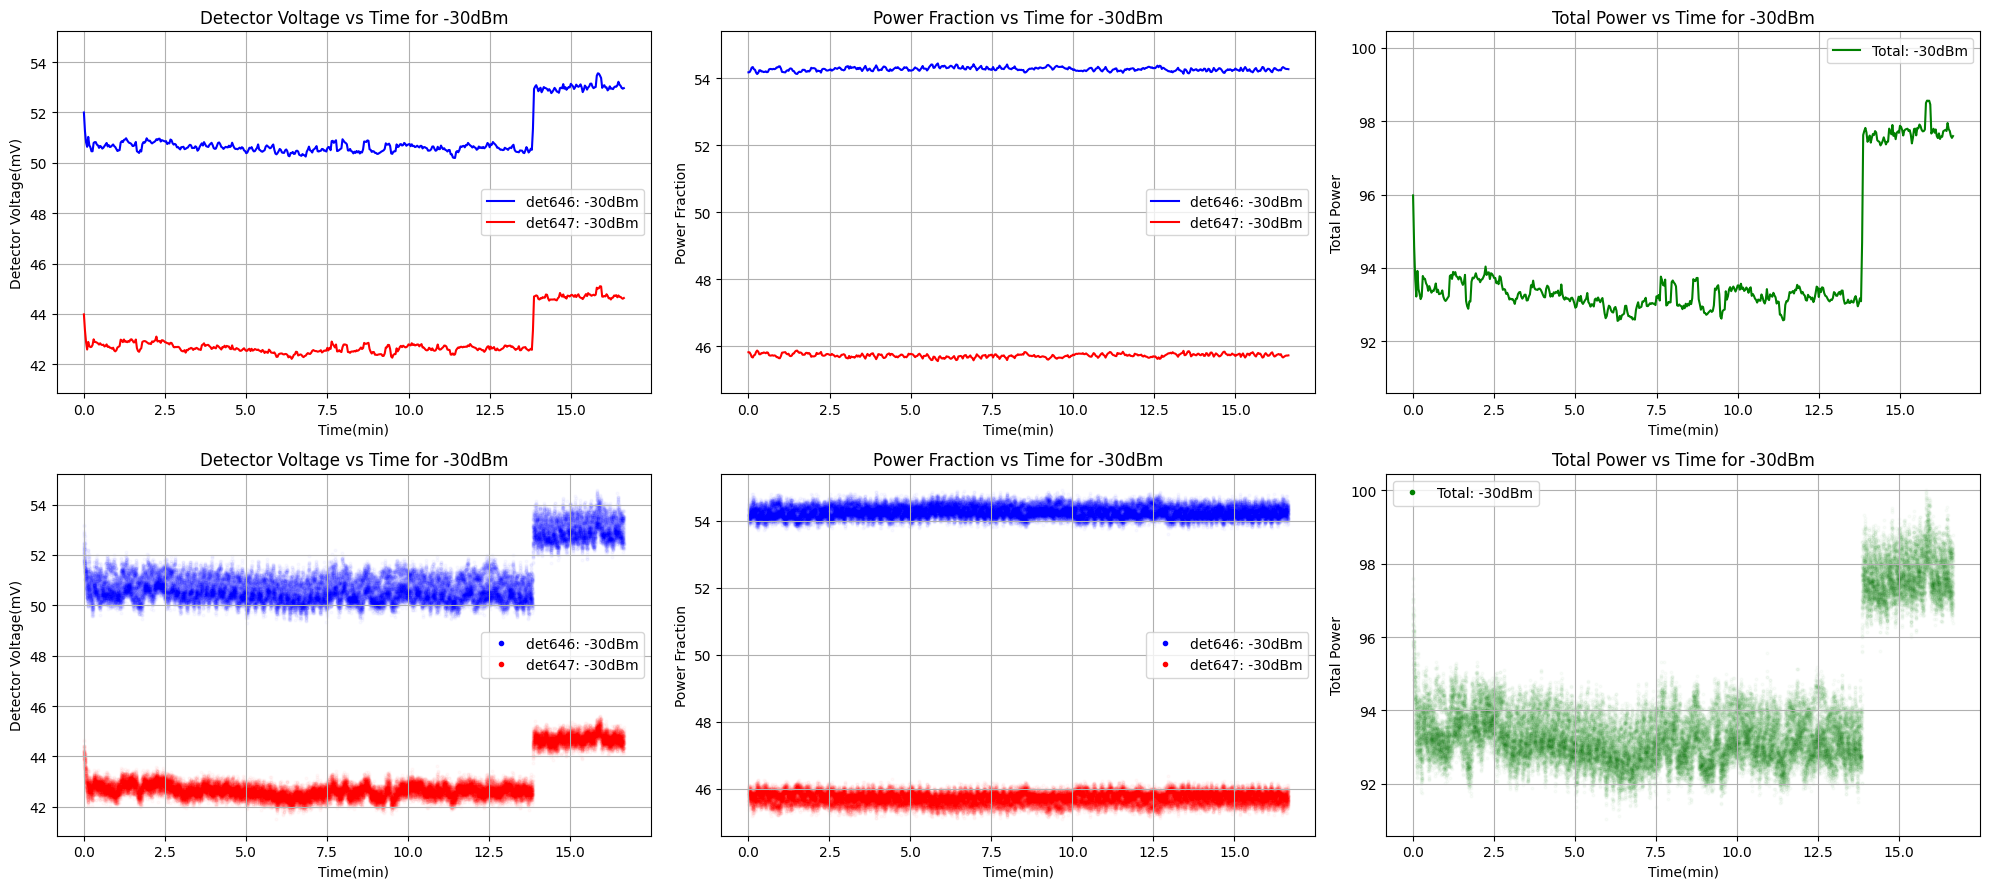

In [13]:
SeriesPlot(ver='v6', PWR='-30', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



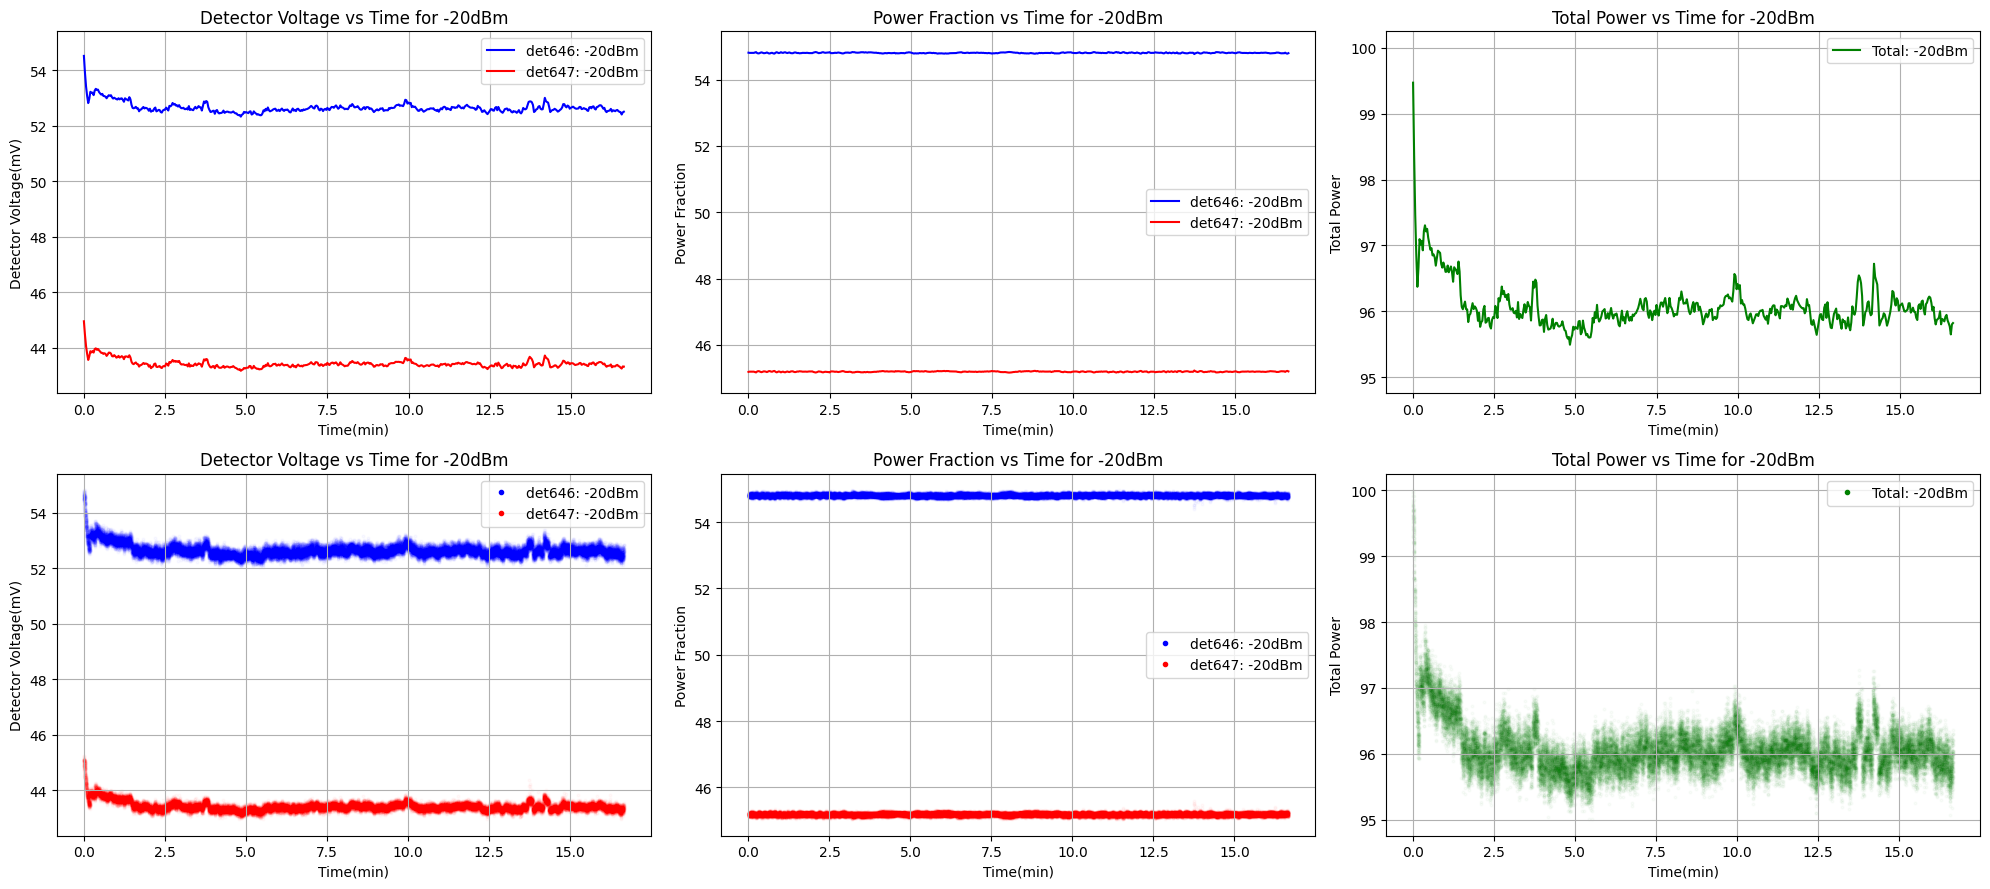

In [14]:
SeriesPlot(ver='v6', PWR='-20', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



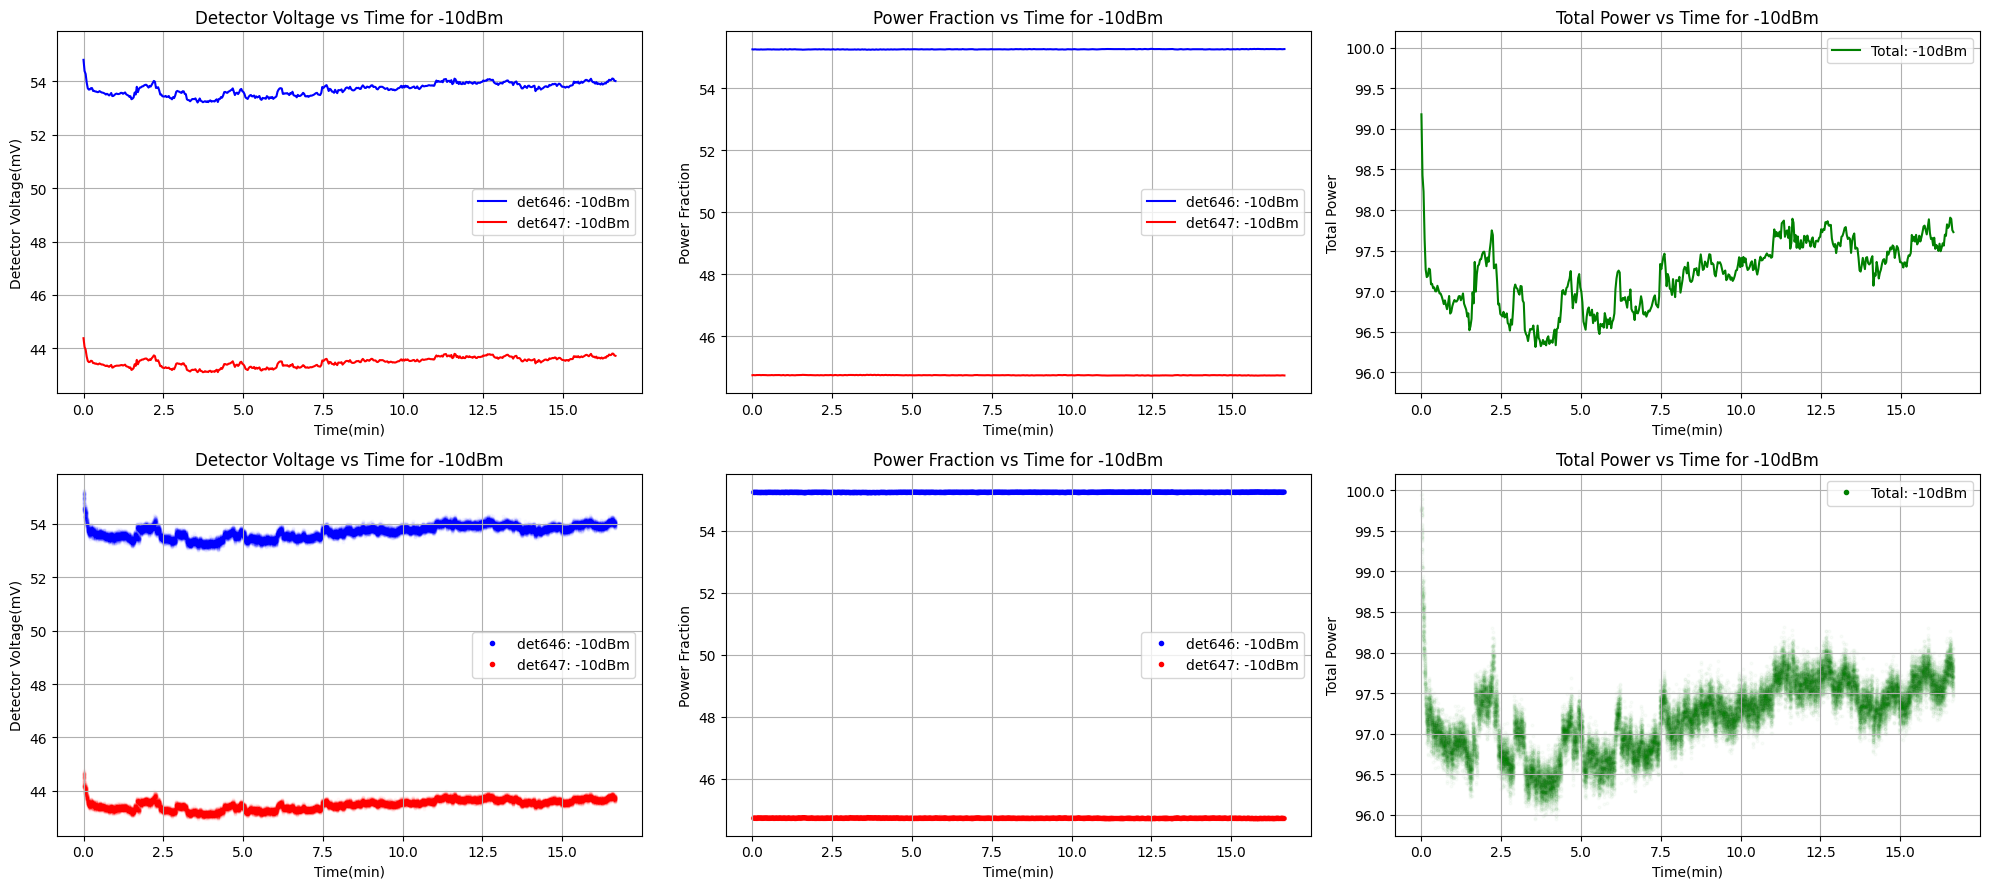

In [15]:
SeriesPlot(ver='v6', PWR='-10', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



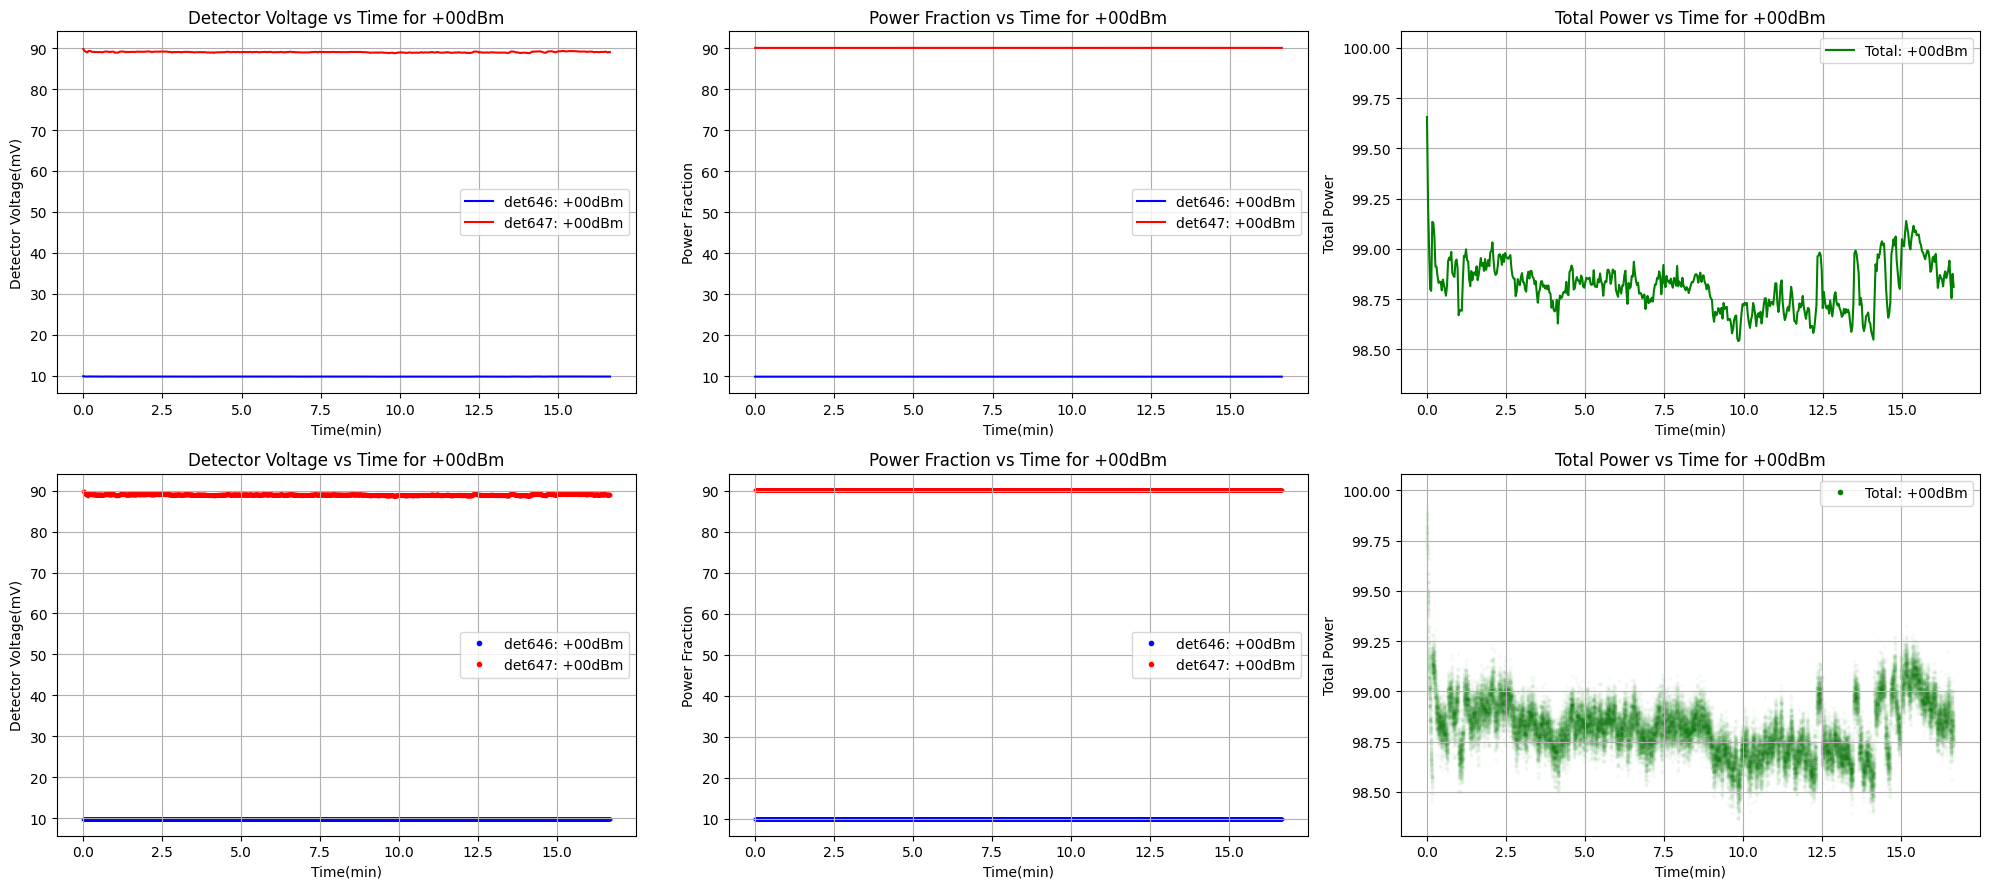

In [16]:
SeriesPlot(ver='v6', PWR='+00', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



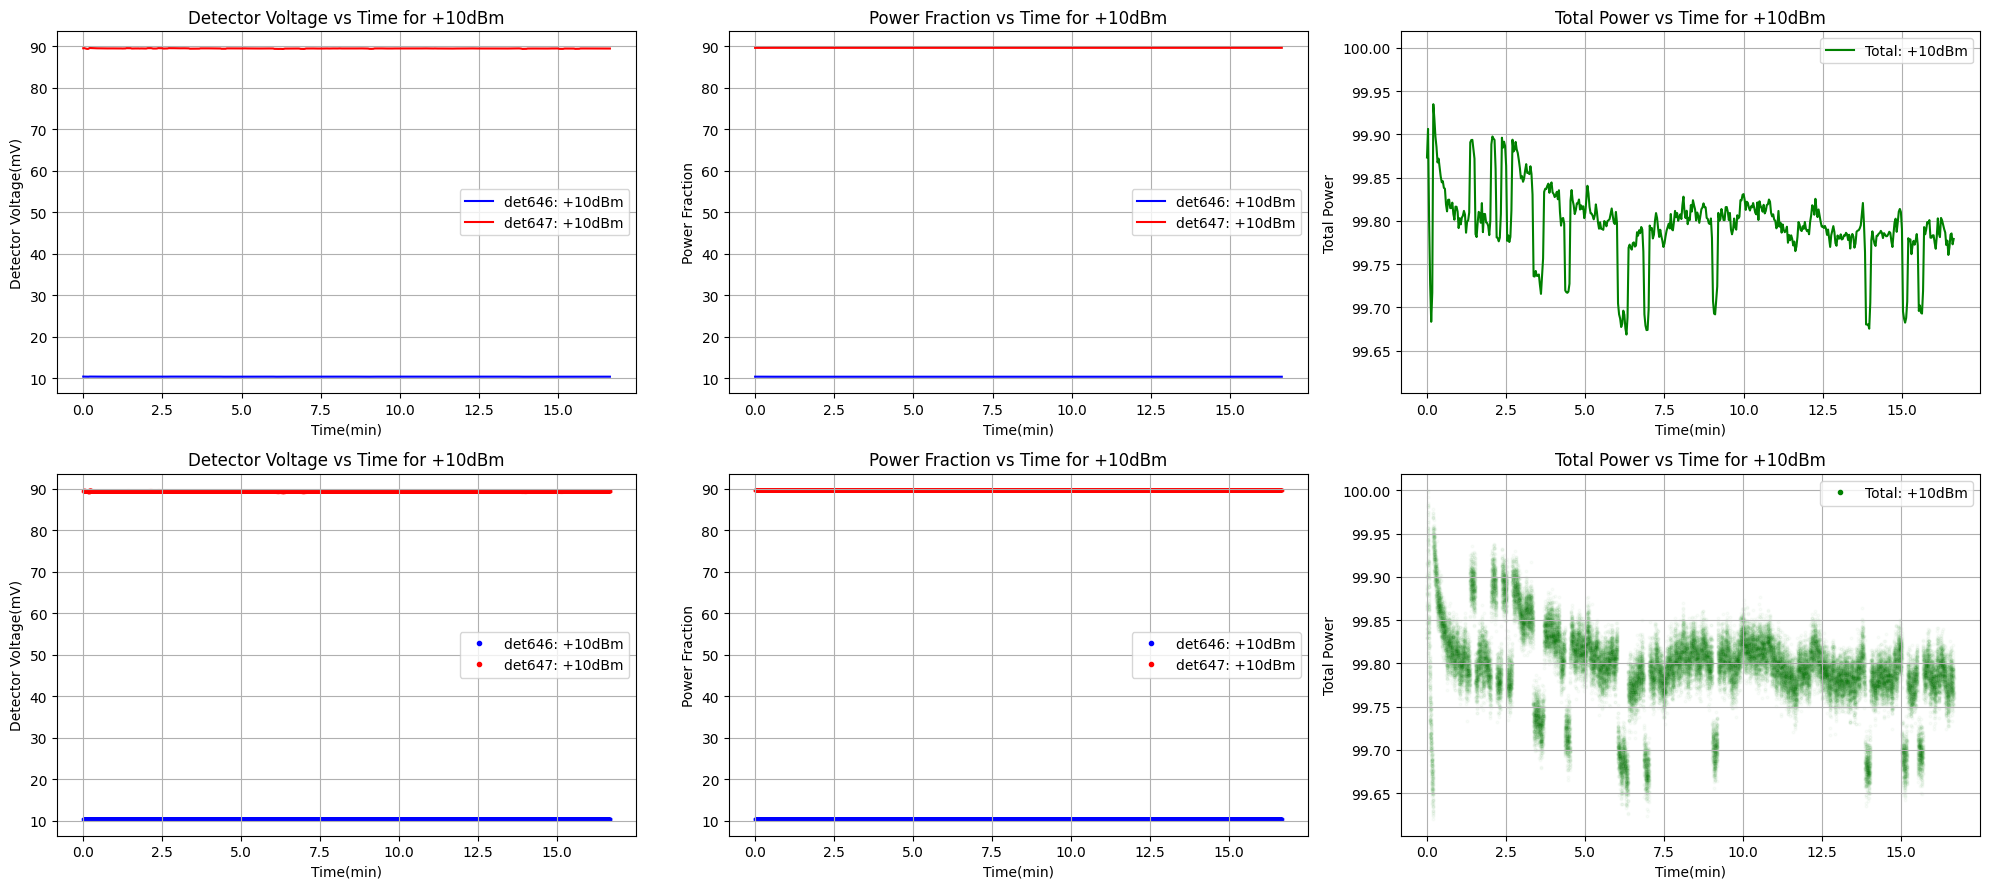

In [17]:
SeriesPlot(ver='v6', PWR='+10', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



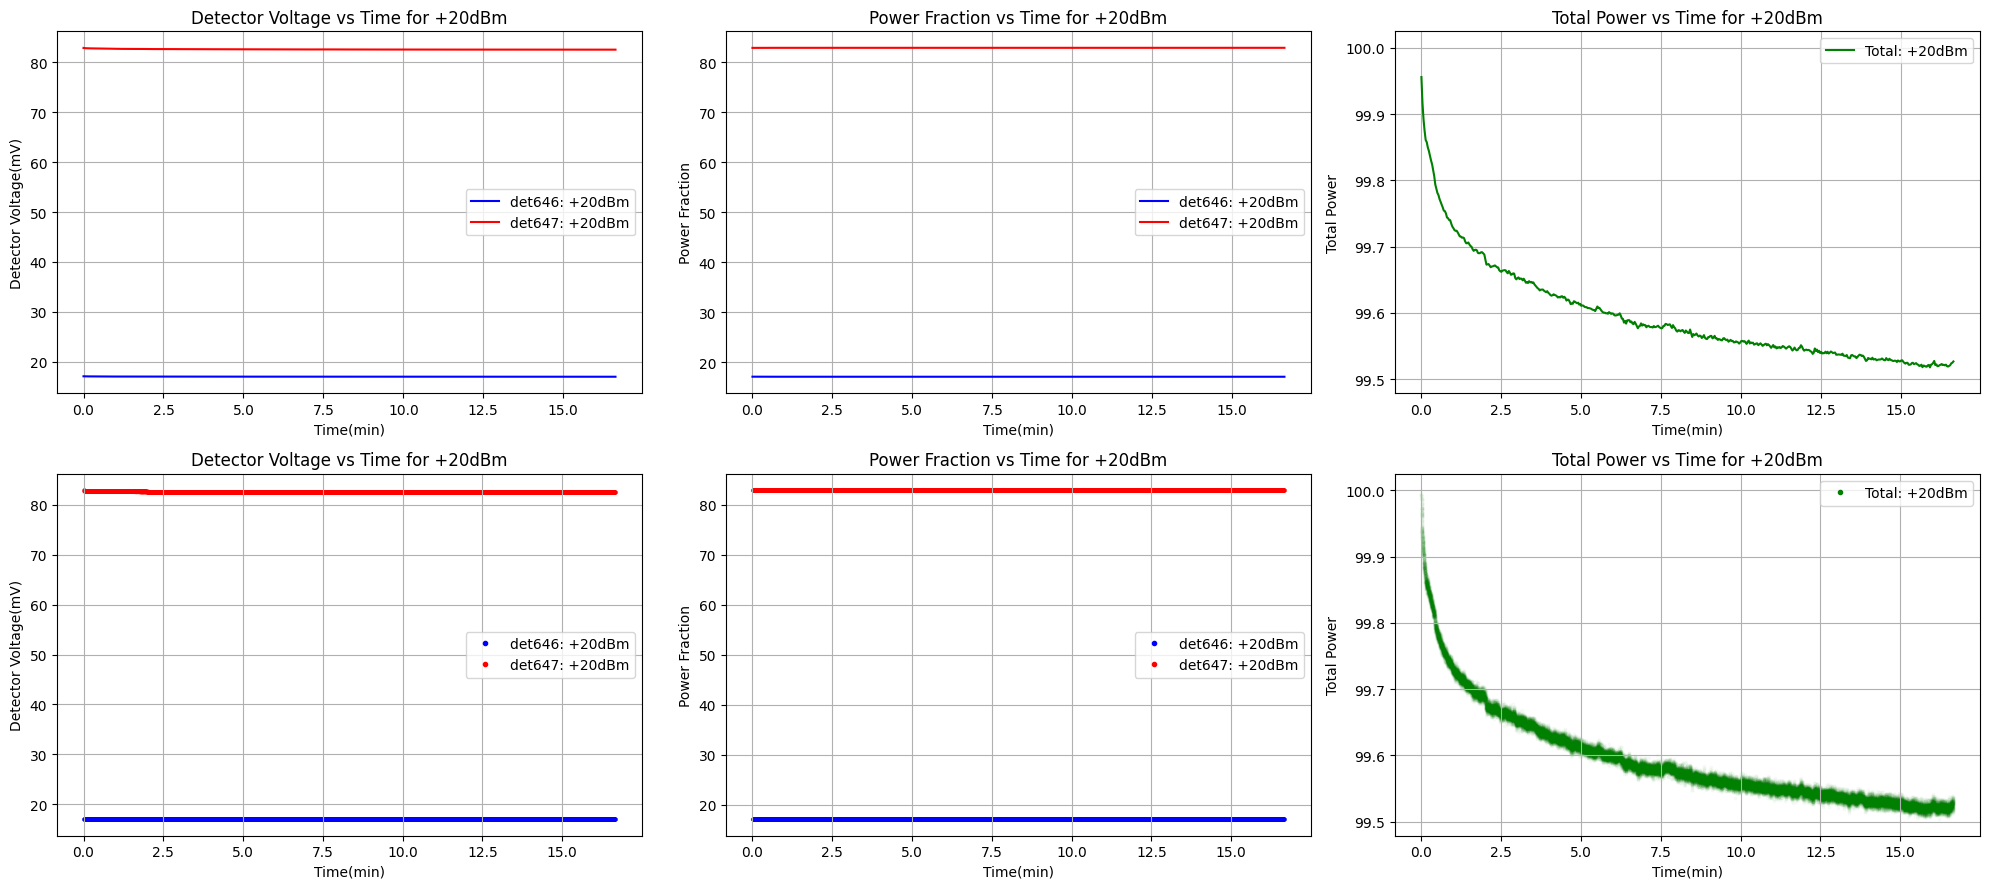

In [18]:
SeriesPlot(ver='v6', PWR='+20', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv4, timescale='minutes')

## 2 way splitter data, optimize power level

In [19]:
#v7: 500us aperture 50Hz sampling 2way splitter to QH1 settings in pictures Alt Source
#-10dBm 13:47 7/16
#+00dBm 14:08 7/16
#+10dBm 14:26 7/16
#+16dBm 14:45 7/16

In [20]:
Normv5 = True

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



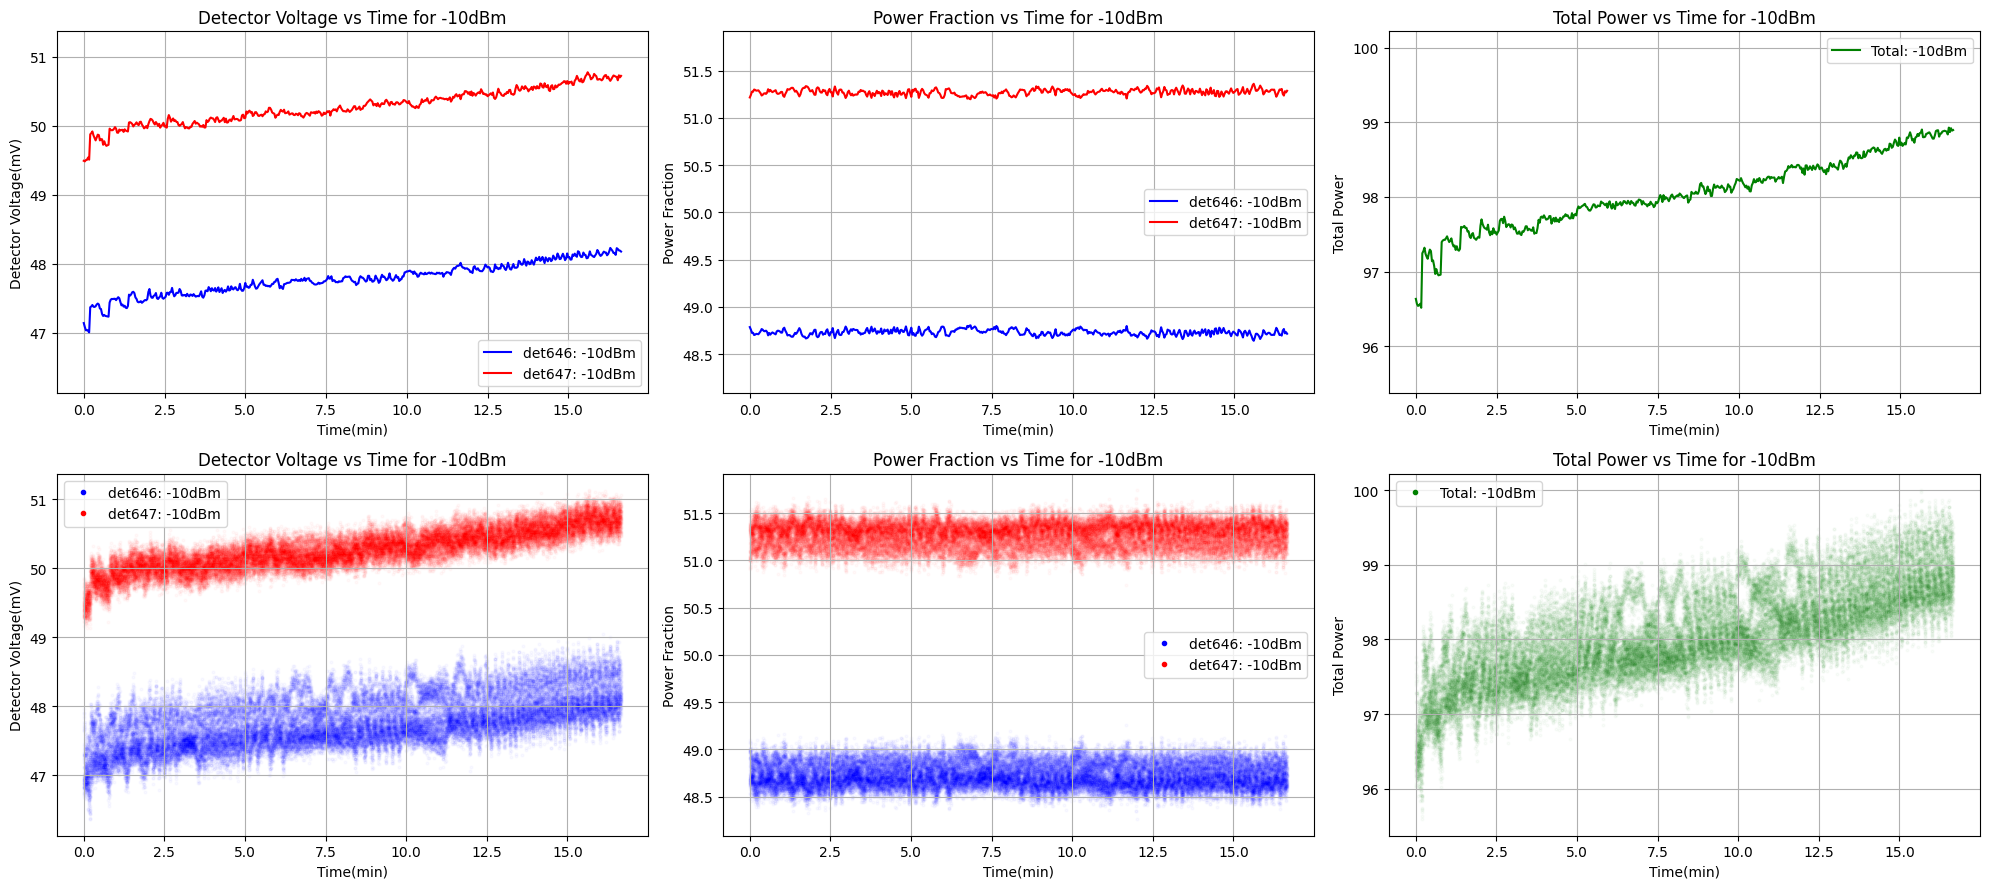

In [21]:
SeriesPlot(ver='v7', PWR='-10', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv5, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



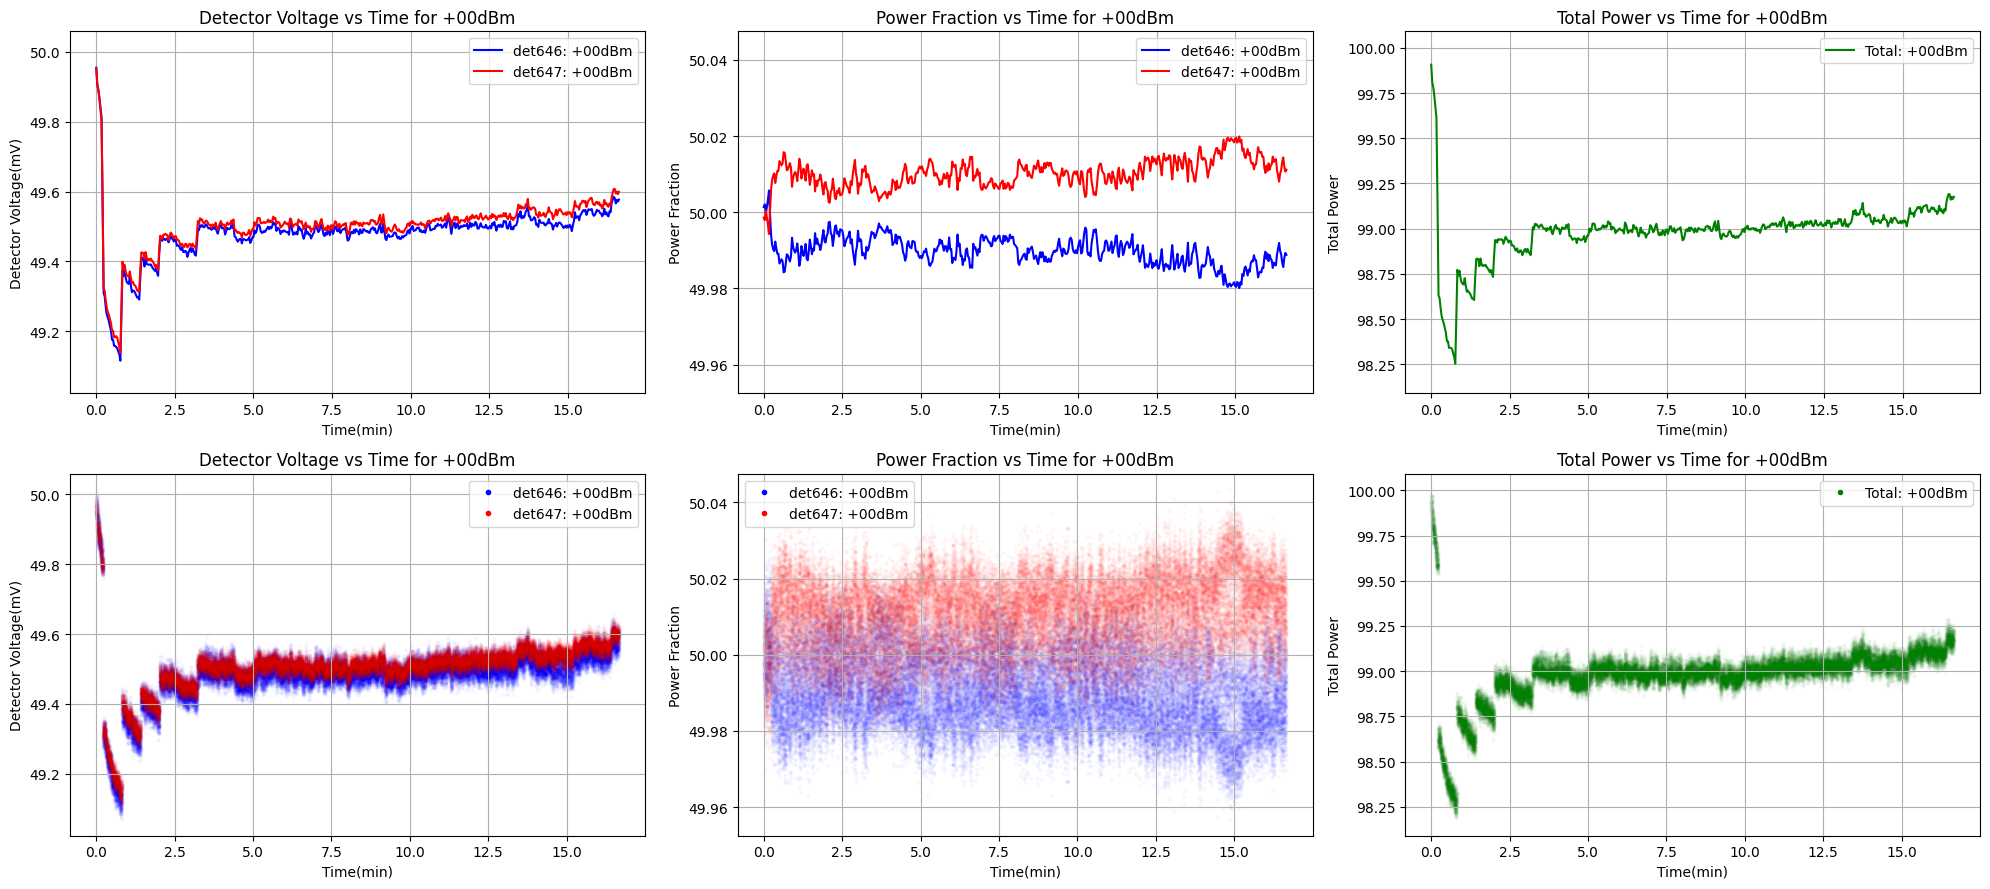

In [22]:
SeriesPlot(ver='v7', PWR='+00', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv5, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



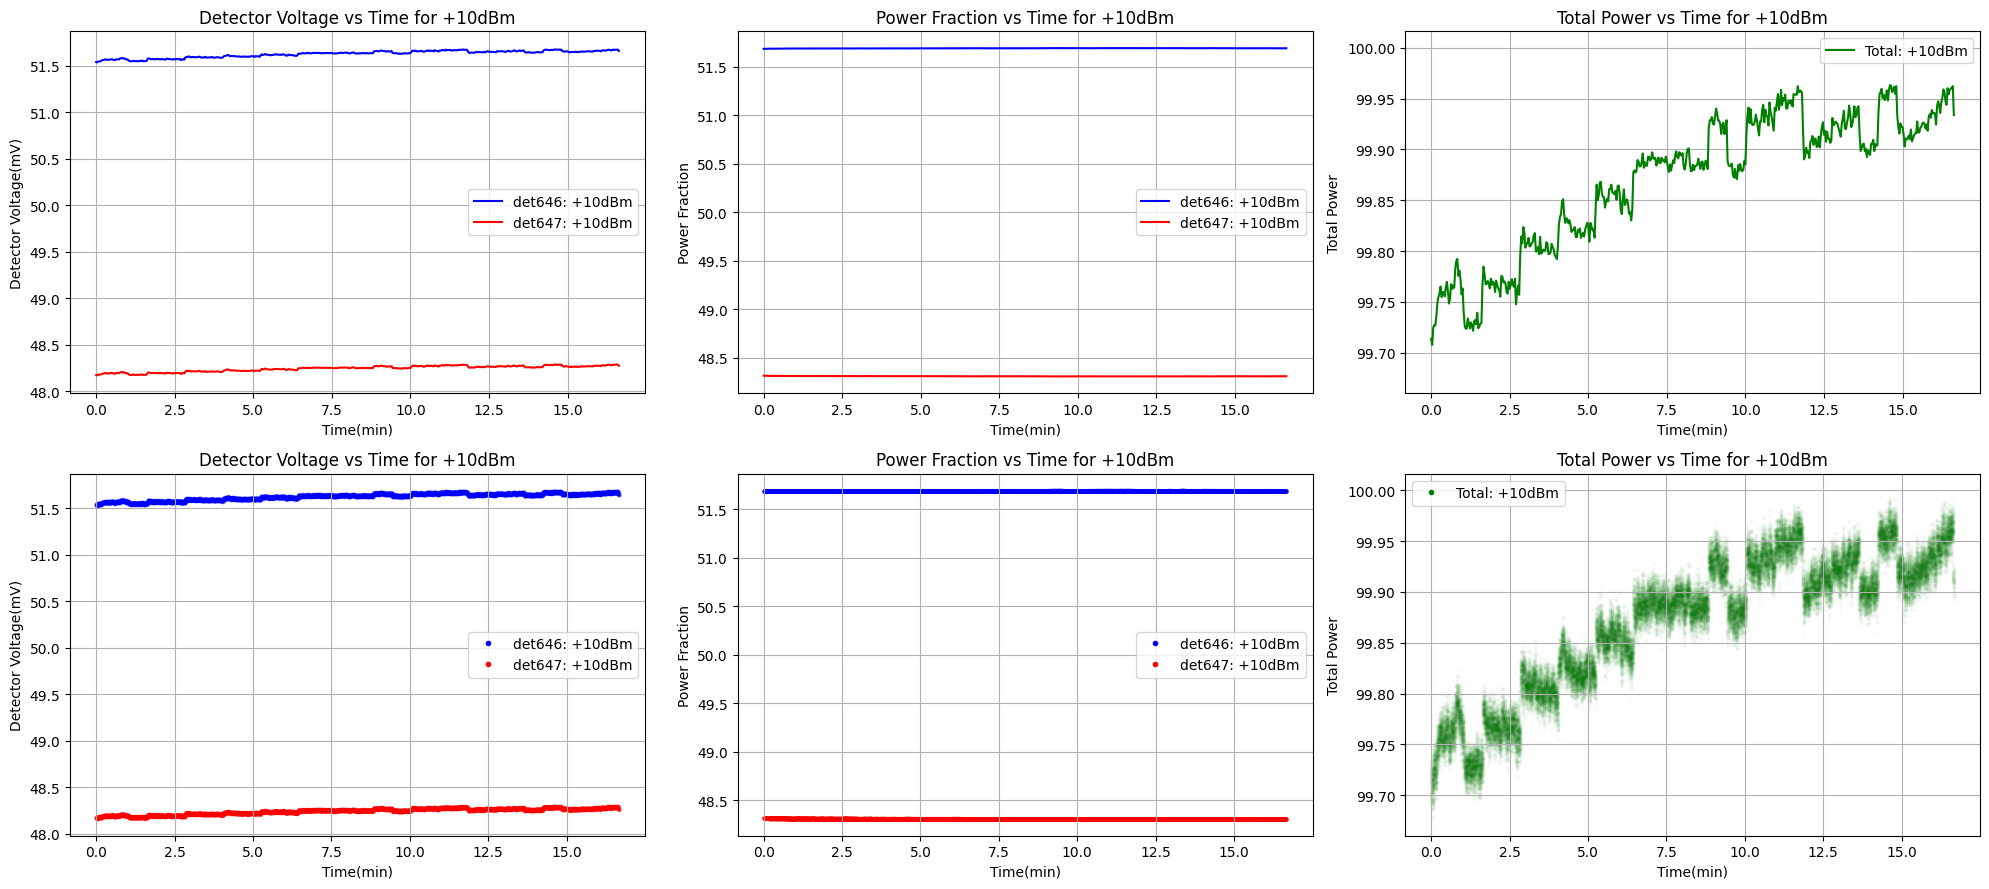

In [23]:
SeriesPlot(ver='v7', PWR='+10', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv5, timescale='minutes')

There are 50000 Points In Total
The Sampling Rate is 50Hz
Aperture is 500 μs
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are minutes
Signal Is Normalized



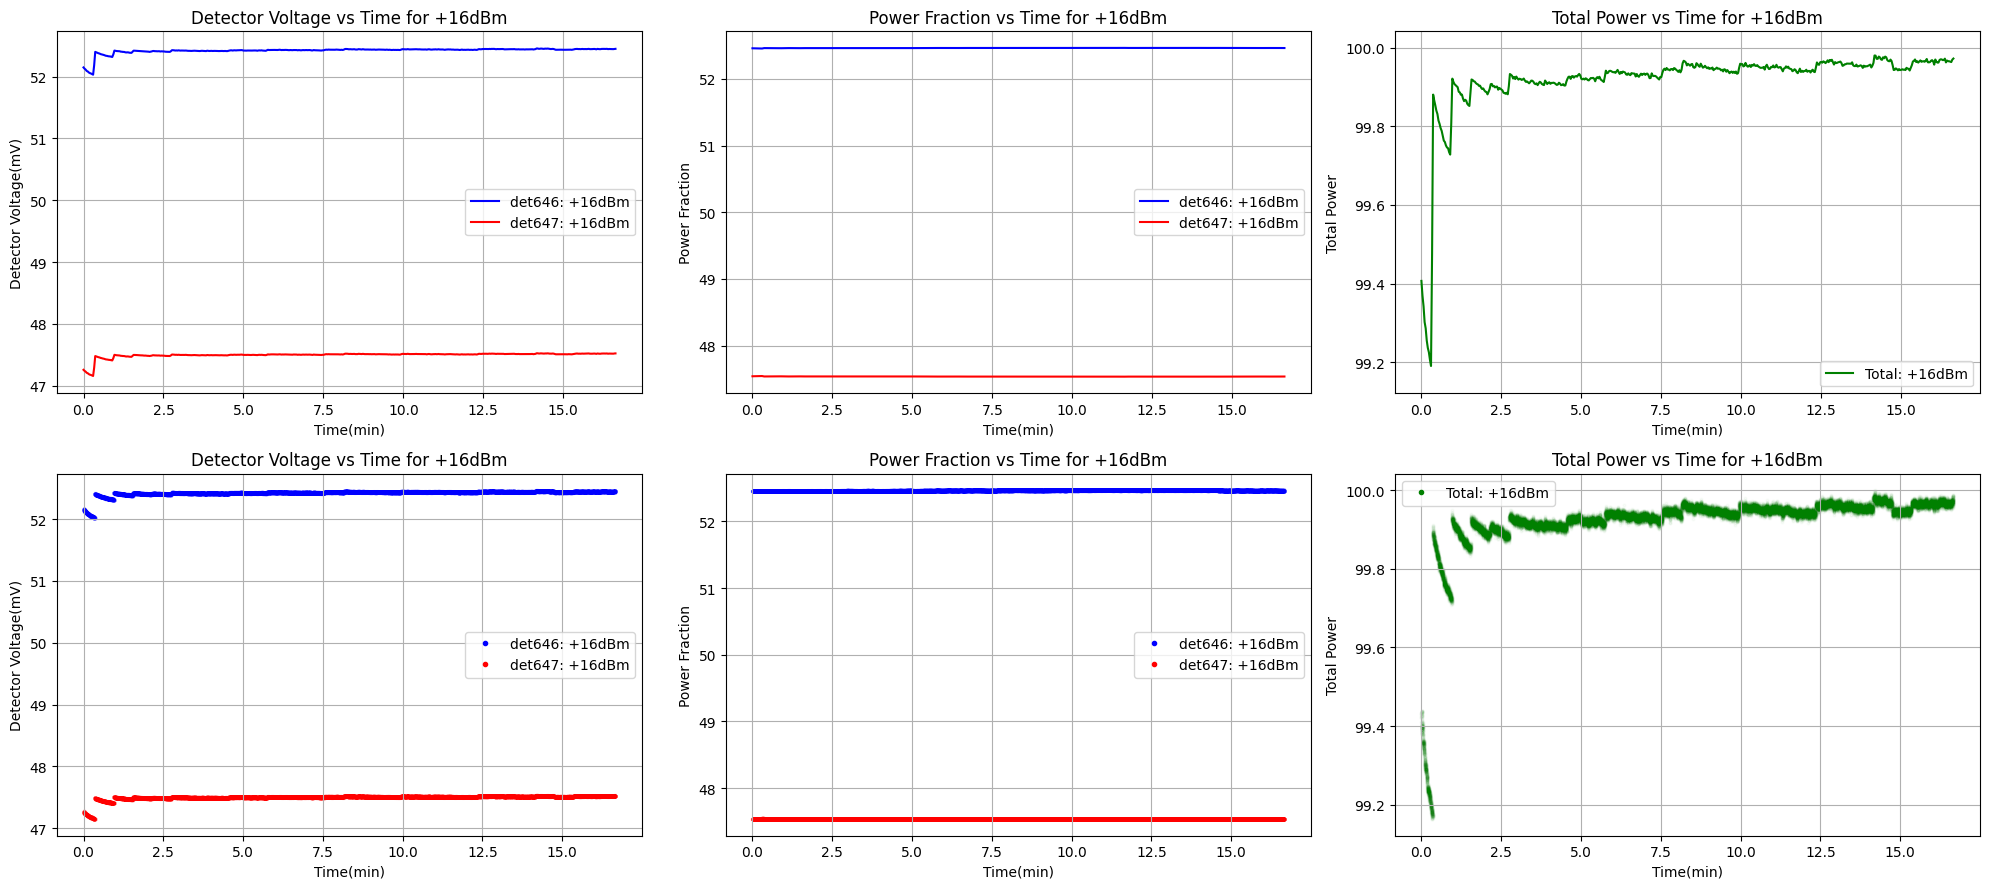

In [24]:
SeriesPlot(ver='v7', PWR='+16', sampling_freq=50, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=500e-6, figsize=(20,9), alpha=0.025, size=4, normalized=Normv5, timescale='minutes')

## 2 way splitter, source stability over time

I am repeating the setup, using the optimal settings I have found to examine the stability of the source power over time

In [25]:
#Testing source stability sample rate 300000 max but keithly only outputs 100k
#+16dBm v8fail New source 11:15 7/17
#+16dBm v8fail Source A 12:58 7/17
#Try again, splitter and phase shift to QH combine.
#source A 16dBm 10:44 7/19
#new Source 16dBm 10:44 7/22

In [26]:
Normv6 = True

There are 50000 Points In Total
The Sampling Rate is 1Hz
Aperture is 50 ms
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are hours
Signal Is Normalized



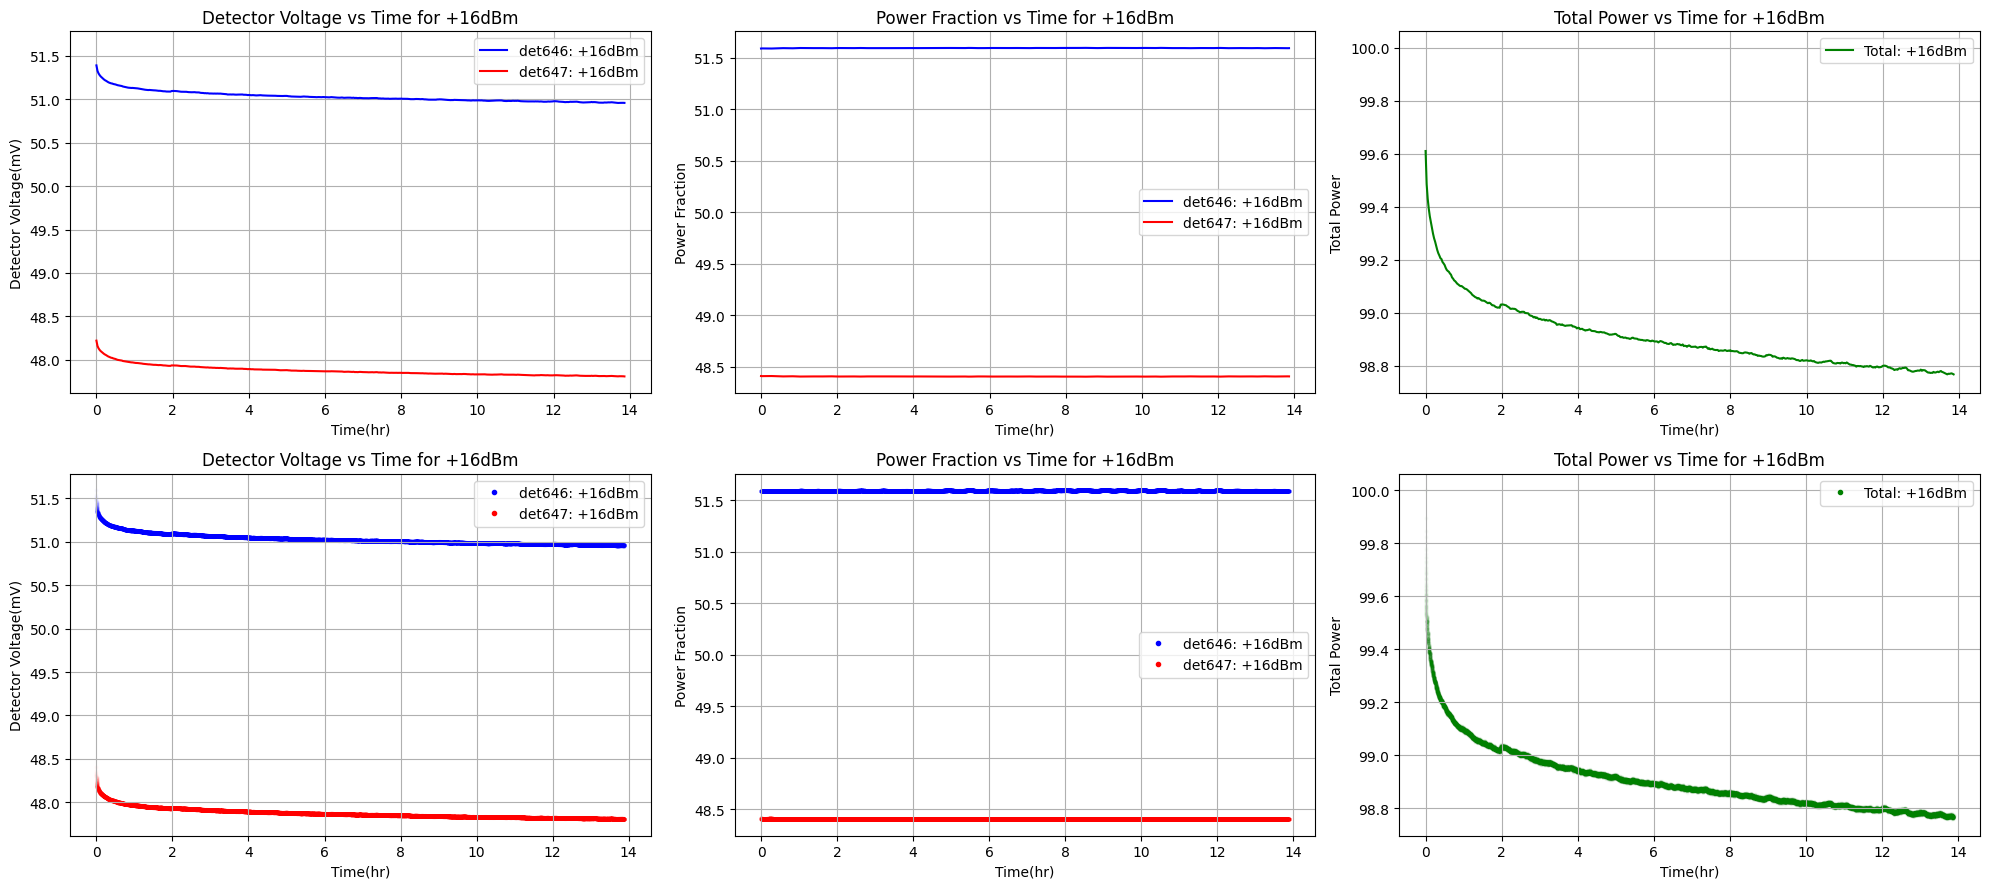

In [27]:
SeriesPlot(ver='v8', PWR='+16', sampling_freq=1, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=50e-3, figsize=(20,9), alpha=0.025, size=4, normalized=Normv6, timescale='hours')